In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch

# Handling data temporality with neural networks"

As seen in class, the basic form of a neural network is the feed forward neural network

A feed forward neural network with $L$ layers, where each layer $l$ has $n_l$ neurons can be described as below:

for a layer $l$ we have $n_l$ neurons :

$
\mathbf{h}^{(l)} = f^{(l)}\left(\mathbf{W}^{(l)} \mathbf{h}^{(l-1)} + \mathbf{b}^{(l)}\right),
$

where :

- $ \mathbf{h}^{(l-1)} \in \mathbb{R}^{n_{l-1}} $ is the activation vector of the previous layer ($\mathbf{h}^{(0)} = x$).
- $ \mathbf{W}^{(l)} \in \mathbb{R}^{n_l \times n_{l-1}} $ is the weight matrice.
- $ \mathbf{b}^{(l)} \in \mathbb{R}^{n_l} $ is the bias.
- $ f^{(l)} $ is an activation function.
- $ \mathbf{h}^{(l)} \in \mathbb{R}^{n_l} $ is the activation vector of the layer $ l $.

$
\hat{\mathbf{y}} = f^{(L)} \circ f^{(L-1)} \circ \dots \circ f^{(1)}(\mathbf{x}),
$


![notimportantname](../fig/neural_net_FF.png)


The basic feedforward architecture is not well-suited for time series because it lacks mechanisms to model temporal dependencies or capture sequential relationships between data points, which are essential for understanding patterns over time. To better capture the temporal dependencies and sequential patterns inherent in the data, more advanced architectures have been developed, specifically designed for processing temporal data


## Recurrent Neural Networks (RNNs)

Recurrent Neural Networks (RNNs) are a class of neural networks designed to process sequential data by capturing temporal dependencies. Unlike feedforward networks, RNNs have a feedback loop, allowing information to persist across time steps.


- **Temporal Dependencies:** RNNs model sequences by maintaining a hidden state $ \mathbf{h}_t $, which evolves over time based on the current input and the previous state:
  $
  \mathbf{h}_t = f(\mathbf{W}_h \mathbf{h}_{t-1} + \mathbf{W}_x \mathbf{x}_t + \mathbf{b}),
  $
  where:
  - $ \mathbf{x}_t $: Input at time $ t $,
  - $ \mathbf{h}_{t-1} $: Hidden state from the previous time step,
  - $ f $: Activation function.

- **Shared Parameters:** The same weights $ \mathbf{W}_h, \mathbf{W}_x $ are used at each time step, making RNNs efficient for sequential data. 

<img src="../fig/neural_net_RNN.png" alt="uselesstitle" width="600px">

Given a sequence of inputs $ x = \{x_1, x_2, \dots, x_T\} \in \mathbb{R}^{c \times T}$, the RNN model computes the outputs $ y = \{y_1, y_2, \dots, y_T\} $ as follows:

#### Initialization
- Initialize the hidden state:
  $
  h_0 = \mathbf{0} \quad \text{(a zero vector of size \texttt{hidden\_size})}
  $

#### Sequential Processing
For each timestep $ t = 1, 2, \dots, T $:
- Compute the new hidden state:
  $
  h_t = \sigma \left( W_{xh} \cdot x_t + W_{hh} \cdot h_{t-1} + b_h \right)
  $
  Where:
  - $ x_t $ is the input at timestep $ t $,
  - $ W_{xh} $ maps the input to the hidden state (in $\mathbb{R}^{c \times h}$),
  - $ W_{hh} $ maps the previous hidden state to the current hidden state (in $\mathbb{R}^{h \times h}$),
  - $ b_h $ is the bias for the hidden state (in $\mathbb{R}^{h}$),
  - $ \sigma $ is the activation function.

- Compute the output:
  $
  y_t = W_{hy} \cdot h_t + b_y
  $
  Where:
  - $ W_{hy} $ maps the hidden state to the output,
  - $ b_y $ is the bias for the output.

- Store the output $ y_t $



In [49]:
class RNN:
    def __init__(self, input_size, hidden_size, output_size, activation=np.tanh):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.activation = activation

        self.Wxh = np.random.randn(hidden_size, input_size) * 0.01
        self.Whh = np.random.randn(hidden_size, hidden_size) * 0.01
        self.Why = np.random.randn(output_size, hidden_size) * 0.01

        self.bh = np.zeros((hidden_size, 1))
        self.by = np.zeros((output_size, 1))

    def __call__(self, inputs):
        h = np.zeros((self.hidden_size, 1))
        outputs = []

        for x in inputs:
            x = x.reshape(-1, 1)
            h = self.activation(np.dot(self.Wxh, x) + np.dot(self.Whh, h) + self.bh)
            y = np.dot(self.Why, h) + self.by
            outputs.append(y)

        return np.array(outputs).squeeze()


input_size = 1
hidden_size = 5
output_size = 2

rnn = RNN(input_size, hidden_size, output_size)

inputs = np.array([1,1,1,1])
print(rnn(inputs).shape) # input_length x output_size
rnn(inputs)[-1,:] # Return the last line only


(4, 2)


array([ 2.41771089e-06, -3.85785918e-04])

### Gradients for RNN

We use back propagation through time to compute the gradients of the RNN (thanks to this [site](https://dennybritz.com/posts/wildml/recurrent-neural-networks-tutorial-part-3/))

Since we are using the Mean Square Error as the loss function
$
l(y, \hat{y}) = \frac{1}{N} \sum_{t=1}^{T} (y_t - \hat{y}_t)^2
$

Where $ \hat{y}_t $ is the prediction of the RNN at step $ t $,

We have:


$
\frac{\partial l}{\partial y_t} = 2 \cdot (y_t - \hat{y}_t)
$

#### Gradient wrt $h_t$ 

$
\frac{\partial l}{\partial h_t} = \frac{\partial l}{\partial y_t} \cdot \frac{\partial y_t}{\partial h_t}
$

And:

$
\frac{\partial y_t}{\partial h_t} = W_{hy}
$

Using chain rule we have:

$
\frac{\partial l}{\partial h_t} = \frac{\partial l}{\partial y_t} \cdot W_{hy}
$

#### Gradient of tanh

Since the activation function is $ \tanh $, we have the following derivates :

$
\frac{\partial \tanh(h_t)}{\partial h_t} = 1 - \tanh^2(h_t)
$

Then we have :

$
\frac{\partial l}{\partial h_t} = \frac{\partial l}{\partial h_t} \cdot (1 - h_t^2)
$

#### Gradients wrt the weights at current states

We have :

$
\frac{\partial l}{\partial W_{xh}} = \frac{\partial l}{\partial h_t} \cdot x_t^T
$

The gradient of the loss function wrt $ W_{hh} $ is :

$
\frac{\partial l}{\partial W_{hh}} = \sum_{t} \frac{\partial l}{\partial h_t} \cdot h_{t-1}^T
$

#TODO Continuer



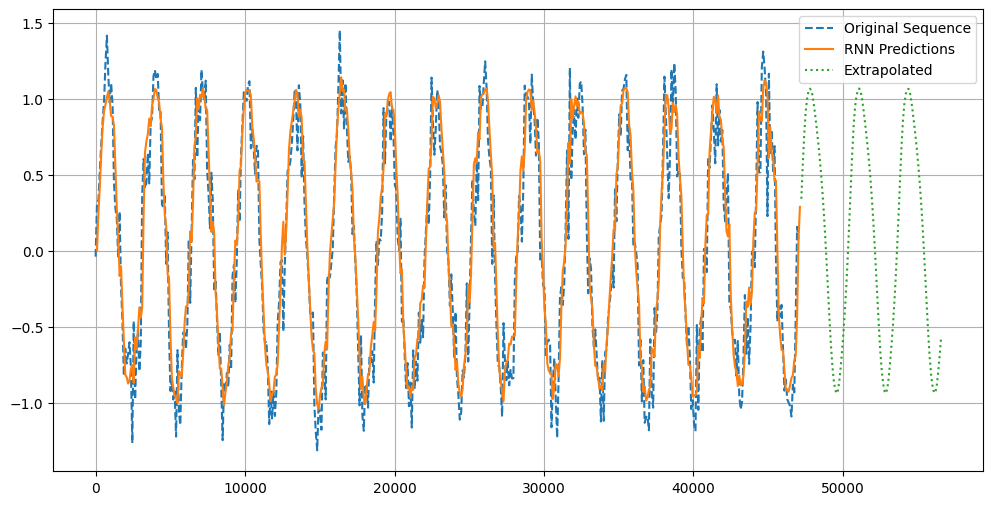

In [7]:
class RNN:
    def __init__(self, input_size, hidden_size, output_size, activation=np.tanh):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.activation = activation
        self.activation_derivative = lambda x: 1 - np.tanh(x)**2

        self.Wxh = np.random.randn(hidden_size, input_size) * 0.01
        self.Whh = np.random.randn(hidden_size, hidden_size) * 0.01
        self.Why = np.random.randn(output_size, hidden_size) * 0.01

        self.bh = np.zeros((hidden_size, 1))
        self.by = np.zeros((output_size, 1))

    def __call__(self, inputs):
        h = np.zeros((self.hidden_size, 1))
        outputs = []
        states = [h]

        for x in inputs:
            x = x.reshape(-1, 1)
            h = self.activation(np.dot(self.Wxh, x) + np.dot(self.Whh, h) + self.bh)
            y = np.dot(self.Why, h) + self.by
            outputs.append(y)
            states.append(h)

        return np.array(outputs).squeeze(), states

    def backward(self, inputs, targets, states, outputs):
        dWxh, dWhh, dWhy = np.zeros_like(self.Wxh), np.zeros_like(self.Whh), np.zeros_like(self.Why)
        dbh, dby = np.zeros_like(self.bh), np.zeros_like(self.by)
        dh_next = np.zeros((self.hidden_size, 1))

        for t in reversed(range(len(inputs))):
            x_t = inputs[t].reshape(-1, 1)
            y_t = outputs[t].reshape(-1, 1)
            h_t = states[t+1]
            h_prev = states[t]

            dy = y_t - targets[t].reshape(-1, 1)
            dWhy += np.dot(dy, h_t.T)
            dby += dy
            dh = np.dot(self.Why.T, dy) + dh_next
            dh_raw = dh * self.activation_derivative(h_t)
            dWxh += np.dot(dh_raw, x_t.T)
            dWhh += np.dot(dh_raw, h_prev.T)
            dbh += dh_raw
            dh_next = np.dot(self.Whh.T, dh_raw)

        return dWxh, dWhh, dWhy, dbh, dby

    def update_weights(self, gradients, learning_rate=0.01):
        dWxh, dWhh, dWhy, dbh, dby = gradients

        self.Wxh -= learning_rate * dWxh
        self.Whh -= learning_rate * dWhh
        self.Why -= learning_rate * dWhy
        self.bh -= learning_rate * dbh
        self.by -= learning_rate * dby

    def train(self, inputs, targets, learning_rate=0.01):
        outputs, states = self(inputs)
        gradients = self.backward(inputs, targets, states, outputs)
        self.update_weights(gradients, learning_rate)
        loss = np.mean((outputs - targets) ** 2)
        return loss


# We generate synthetic data

def generate_sine_wave(length, n_waves=30, amplitude=1, frequency=0.1, noise=0.2):
    x = np.linspace(0, n_waves * np.pi * frequency * length, length)
    y = amplitude * np.sin(x) + noise * np.random.randn(length)
    return x, y

sequence_length = 500
x, y = generate_sine_wave(sequence_length, frequency=1)

inputs = y[:-1].reshape(-1, 1)
targets = y[1:].reshape(-1, 1)

input_size = 1
hidden_size = 5
output_size = 1
rnn = RNN(input_size, hidden_size, output_size)

epochs = 2000
learning_rate = 0.01
losses = []

idx = np.random.randint(0, len(y)-30)

for epoch in range(epochs):
    idx = np.random.randint(0, len(y)-30)
    loss = rnn.train(inputs[idx:idx+30], targets[idx:idx+30], learning_rate)
    losses.append(loss)


predictions, _ = rnn(inputs)

extrapolated = []
input_seq = inputs[-1]
list_preds = []
prev = y.copy()

n_preds = 100

for _ in range(n_preds):
    preds = rnn(prev)[0][-1]
    prev = np.append(prev, preds)
    list_preds.append(preds)

plt.figure(figsize=(12, 6))
plt.plot(x[:-1], inputs, label="Original Sequence", linestyle="--")
plt.plot(x[1:], predictions, label="RNN Predictions")
plt.plot(x[-1:] + np.arange(1, n_preds + 1) * (x[1] - x[0]), np.concatenate([list_preds]), label="Extrapolated", linestyle="dotted")
plt.legend()
plt.grid(True)
plt.show()
